In [1]:
from exp.nb_DatasetManager import DatasetManager
from exp.nb_Tesis import *

In [2]:
dm = DatasetManager('2019','train_images',224,300)

In [ ]:
dm.generate_dataset(should_crop=True,force=True)

In [19]:
p = Path(dm.get_dataset_path()); p.rm

In [6]:
def reload_dataset(imgs_folder):
    random_seed(1,True)
    tfms = get_transforms(flip_vert=True, max_rotate=180,max_zoom=1.8, max_lighting=.3,p_affine=1, max_warp=0)

    data = ImageList.from_folder(imgs_folder)\
    .split_by_rand_pct()\
    .label_from_func(dm.get_label_for_image_path)\
    .transform(tfms)\
    .databunch(bs=16)\
    .normalize()
    return data

data = reload_dataset(dm.get_dataset_path())

You can deactivate this warning by passing `no_check=True`.


/home/mike/miniconda3/lib/python3.7/site-packages/fastai/basic_data.py:272: UserWarning: It's not possible to collate samples of your dataset together in a batch.
Shapes of the inputs/targets:
[[torch.Size([3, 320, 320]), torch.Size([3, 320, 320]), torch.Size([3, 320, 426]), torch.Size([3, 320, 320]), torch.Size([3, 320, 428]), torch.Size([3, 320, 320]), torch.Size([3, 320, 320]), torch.Size([3, 320, 426]), torch.Size([3, 320, 320]), torch.Size([3, 320, 320]), torch.Size([3, 320, 320]), torch.Size([3, 320, 426]), torch.Size([3, 320, 320]), torch.Size([3, 320, 320]), torch.Size([3, 320, 426]), torch.Size([3, 320, 426])], [(), (), (), (), (), (), (), (), (), (), (), (), (), (), (), ()]]
  warn(message)


RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 0. Got 426 and 320 in dimension 3 at /tmp/pip-req-build-4baxydiv/aten/src/TH/generic/THTensor.cpp:689

In [ ]:
data.show_batch(3)

In [ ]:
def _plot(i,j,ax):
    x,y = data.train_ds[1]
    x.show(ax, y=y)

plot_multi(_plot, 3, 3, figsize=(8,8))

In [ ]:
train_count,valid_count = pd.value_counts(data.train_ds.y.items),pd.value_counts(data.valid_ds.y.items)
train_count.index,valid_count.index = [data.classes[i] for i in train_count.index],[data.classes[i] for i in valid_count.index]

print('train_count: \n',train_count,'\n\n','valid_count: \n', valid_count)
print('ratios:')
print(valid_count / train_count, '%')

In [ ]:
learner = cnn_learner(data,models.resnet34, metrics=[accuracy])

In [ ]:
learner.fit_one_cycle(4)

In [ ]:
learner.unfreeze()

In [ ]:
learner.fit_one_cycle(10,max_lr=1e-4)

In [9]:
!pip install geffnet


In [7]:
import geffnet
m = geffnet.create_model('efficientnet_b3', pretrained=True, as_sequential=True)
# m.eval()

In [8]:
learn_b0 = Learner(data,m,metrics=[error_rate,accuracy,AUROC()],
                    callback_fns=[ShowGraph])


NameError: name 'data' is not defined

In [52]:
learn_b0.split(lambda x: (x[:13],x[13:]))

Learner(data=ImageDataBunch;

Train: LabelList (1834 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
BCC,BCC,NV,NV,VASC
Path: 2019_train_images_resized_to_320_picked_300;

Valid: LabelList (458 items)
x: ImageList
Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320),Image (3, 320, 320)
y: CategoryList
BKL,AK,DF,VASC,BCC
Path: 2019_train_images_resized_to_320_picked_300;

Test: None, model=Sequential(
  (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SwishJit()
  (3): Sequential(
    (0): DepthwiseSeparableConv(
      (conv_dw): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
      (bn1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): SwishJit()
      (se): Sque

In [53]:
learn_b0.layer_groups

[Sequential(
   (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
   (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): SwishJit()
   (3): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
   (4): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (5): SwishJit()
   (6): AdaptiveAvgPool2d(output_size=1)
   (7): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
   (8): SwishJit()
   (9): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
   (10): Conv2d(40, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (11): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (12): Identity()
   (13): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=24, bias=False)
   (14): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (15): SwishJit()
   (16): AdaptiveAvgPool2d(o

In [55]:
learn_b0.freeze_to(1)

In [56]:
learn_b0.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [40, 160, 160]       1,080      False     
______________________________________________________________________
BatchNorm2d          [40, 160, 160]       80         True      
______________________________________________________________________
SwishJit             [40, 160, 160]       0          False     
______________________________________________________________________
Conv2d               [40, 160, 160]       360        False     
______________________________________________________________________
BatchNorm2d          [40, 160, 160]       80         True      
______________________________________________________________________
SwishJit             [40, 160, 160]       0          False     
______________________________________________________________________
AdaptiveAvgPool2d    [40, 1, 1]           0          False     
___________________________________________________

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,3.042291,2.271076,0.696507,0.303493,0.400897,00:22
1,1.806457,1.751125,0.609170,0.390830,0.419797,00:22
2,1.446177,1.590920,0.565502,0.434498,0.419759,00:22
3,1.314128,1.618582,0.567686,0.432314,0.420957,00:22
4,1.250432,1.538366,0.524017,0.475983,0.419913,00:22


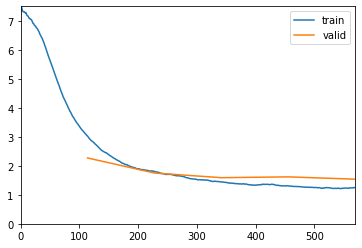

In [57]:
learn_b0.fit_one_cycle(5)

In [58]:
learn_b0.unfreeze()

In [59]:
learn_b0.lr_find()

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.20E-06


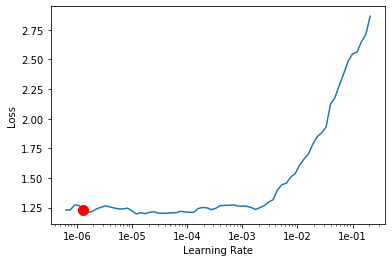

In [64]:
learn_b0.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,1.238191,1.592481,0.532751,0.467249,0.427992,00:31
1,1.211216,1.558277,0.528384,0.471616,0.428958,00:31
2,1.256377,1.578433,0.556769,0.443231,0.438814,00:31
3,1.221575,1.606608,0.563319,0.436681,0.435761,00:31


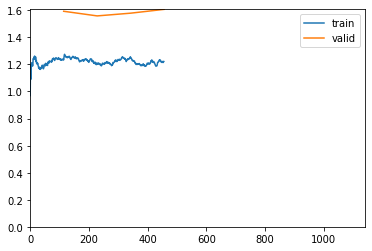

In [ ]:
learn_b0.fit_one_cycle(10,max_lr=1.20E-06)

epoch,train_loss,valid_loss,error_rate,accuracy,auroc,time
0,0.550111,1.053335,0.375546,0.624454,0.604399,00:22
1,0.524518,1.025411,0.329694,0.670306,0.587972,00:22
2,0.491952,1.041427,0.353712,0.646288,0.597557,00:22
3,0.476219,1.038947,0.347162,0.652838,0.579082,00:22


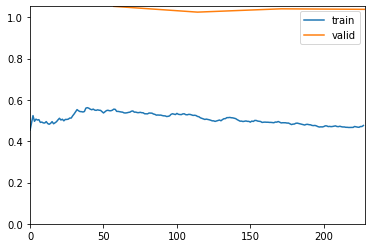

In [12]:
learn_b0.fit_one_cycle(4,max_lr=1e-4)